In [9]:
import pandas as pd
import numpy as np

In [10]:
#步骤1：读取原始数据
file_path = 'example_data_bluetooth.txt'
raw_df =pd.read_csv(file_path,header=None)

In [11]:
#步骤2：提取有效数据列
 # 用于临时存储提取出的数据块列表
all_data_points = []

with open(file_path, 'r') as f:
    lines = f.readlines()

for line in lines:
        # 去除首尾空白字符
        line = line.strip()
        
        # 跳过空行
        if not line:
            continue
            
        # 使用逗号分割每一行
        parts = line.split(',')
        
        # 数据完整性检查：确保行中有足够的数据
        # 即使最后一行可能不完整，标准的行应该包含所有block
        if len(parts) < 40: 
            continue

        try:
            # 格式分析：
            # 前2列是 Header信息: [Timestamp, P] -> 索引 0, 1
            # 之后是数据块，格式为 [C, C, C, C, C, C, C, 0] (7个数据 + 1个分隔符/辅助数据)
            # 这样的块在一行中重复出现 5 次
            
            # 起始索引：第3列（索引2）是第一个Channel数据的开始
            base_index = 2
            
            # 每个数据块的步长：7个Channel数据 + 1个分隔位 = 8
            block_stride = 8
            
            # 一行中有 5 个采样块 (Block)
            for i in range(5):
                # 计算当前块的起始和结束索引
                start = base_index + (i * block_stride)
                end = start + 7 # 我们只需要前7个C，不需要第8个0
                
                # 提取这7个通道的数据并转换为浮点数
                # parts[start:end] 获取切片
                channel_data = [float(val) for val in parts[start:end]]
                
                # 将这一时刻的7个数据点加入总列表
                all_data_points.append(channel_data)
                
        except ValueError:
            # 如果遇到无法转换为float的行（例如文件头Header说明行），则跳过
            continue

    # 将列表转换为 NumPy 数组
    # 此时 shape 是 (Total_Samples, 7)
raw_array = np.array(all_data_points)

    # 转置数组以符合通常的信号处理格式：(Channel_Num, Data_Points)
    # 最终 shape 变为 (7, Total_Samples)
eeg_data  = raw_array.T    


In [12]:
# 3. 打印结果查看
print(f"数据处理完成。")
print(f"数组类型: {type(eeg_data)}")
print(f"数组形状 (Channel_num, Data_points): {eeg_data.shape}")
# 打印前几个数据点以验证 (例如打印 Channel 0 的前10个点)
if eeg_data.size > 0:
    print("\nChannel 0 (第一通道) 的前10个数据点:")
    print(eeg_data[0, :10])
    
    print("\nChannel 6 (第七通道) 的前10个数据点:")
    print(eeg_data[6, :10])

数据处理完成。
数组类型: <class 'numpy.ndarray'>
数组形状 (Channel_num, Data_points): (7, 2325)

Channel 0 (第一通道) 的前10个数据点:
[227.6972  230.37941 234.6933  237.8896  240.37065 243.09756 245.73508
 250.13837 254.51932 256.06158]

Channel 6 (第七通道) 的前10个数据点:
[81.874435 83.43906  84.80251  86.367134 86.94828  86.90358  87.19415
 85.89775  86.00951  84.55665 ]


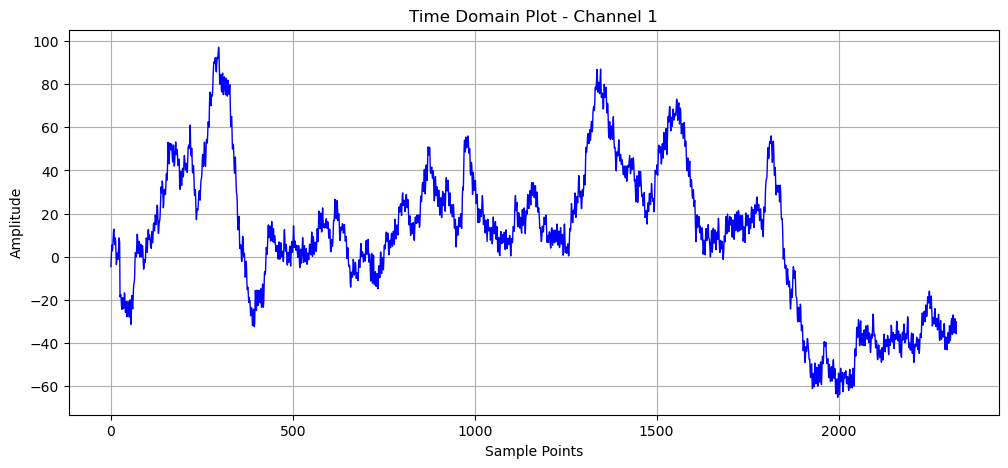

In [13]:
import numpy as np
import matplotlib.pyplot as plt

target_channel = 1 # 选择要查看的通道索引 (0 到 6)

plt.figure(figsize=(12, 5)) # 设置画布大小
plt.plot(eeg_data[target_channel, :], color='blue', linewidth=1)
plt.title(f'Time Domain Plot - Channel {target_channel}') # 标题
plt.xlabel('Sample Points') # X轴：采样点序号
plt.ylabel('Amplitude')     # Y轴：幅值
plt.grid(True)              # 显示网格
plt.show()                  # 显示图像

正在应用带通滤波 (1-100Hz)...
number of segs: 9
开始处理数据: 7 通道, 9 段 (每段 250 点)...


c:\Users\Lenovo\anaconda3\Lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 2048 is greater than input length  = 250, using nperseg = 250
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


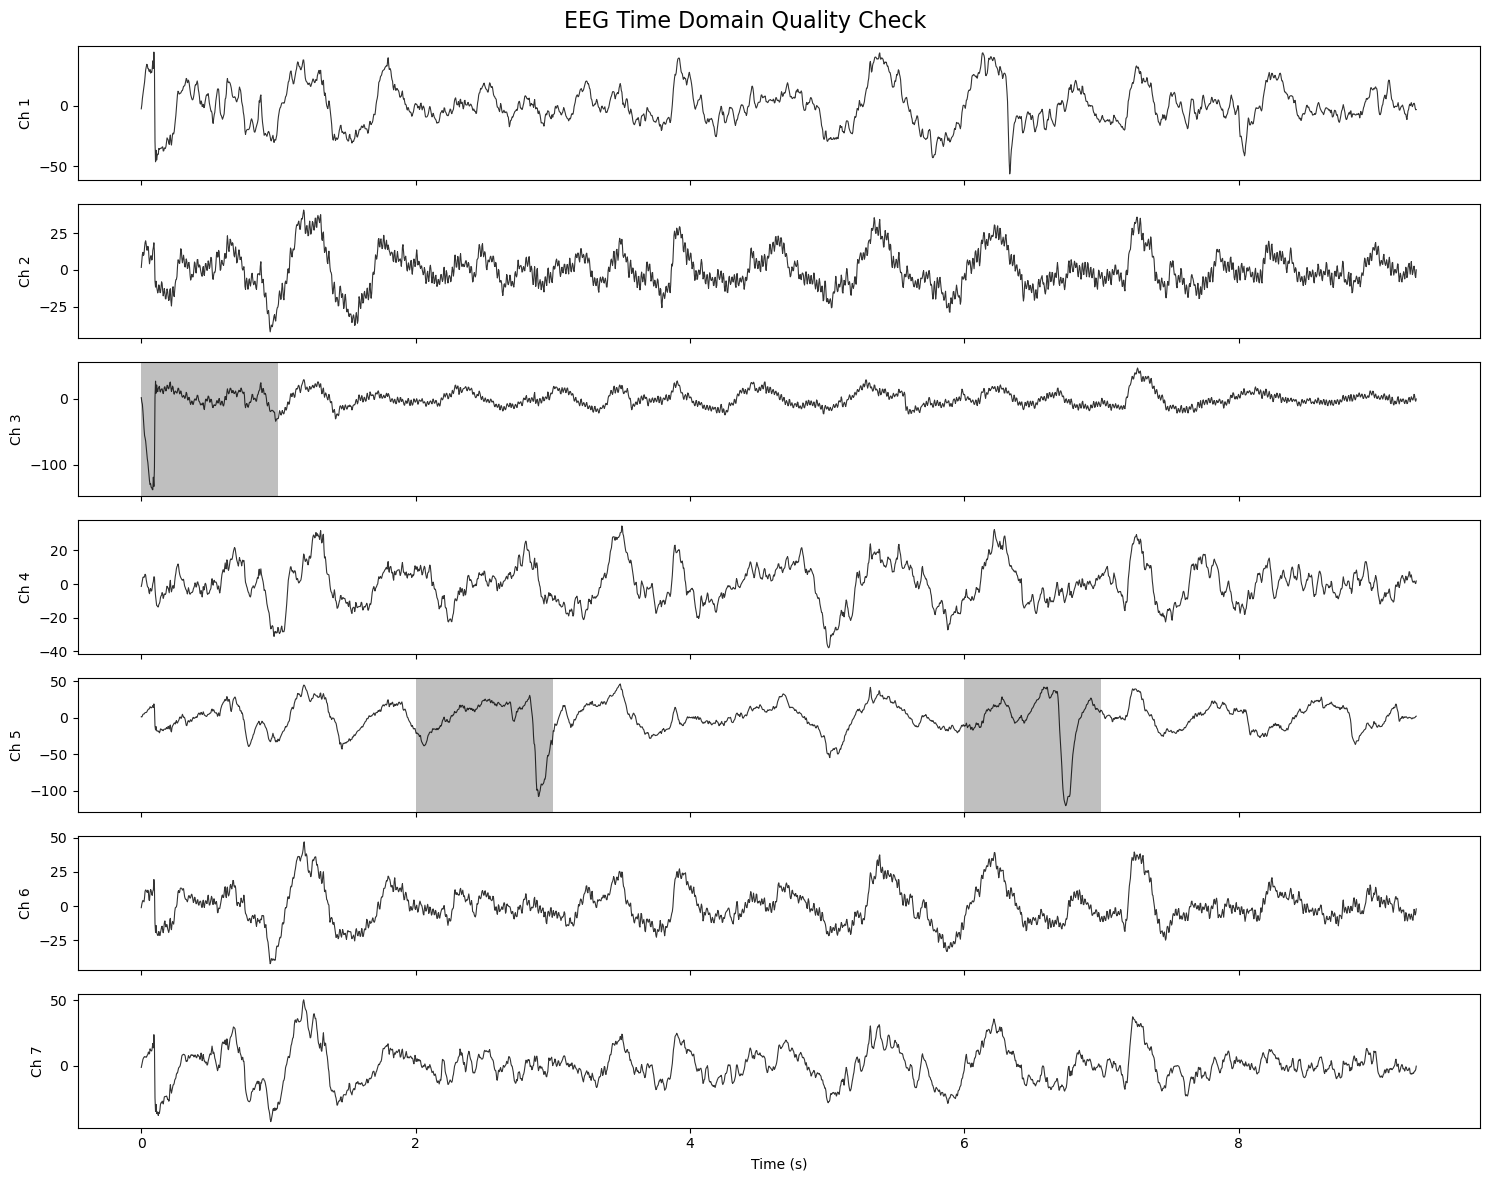

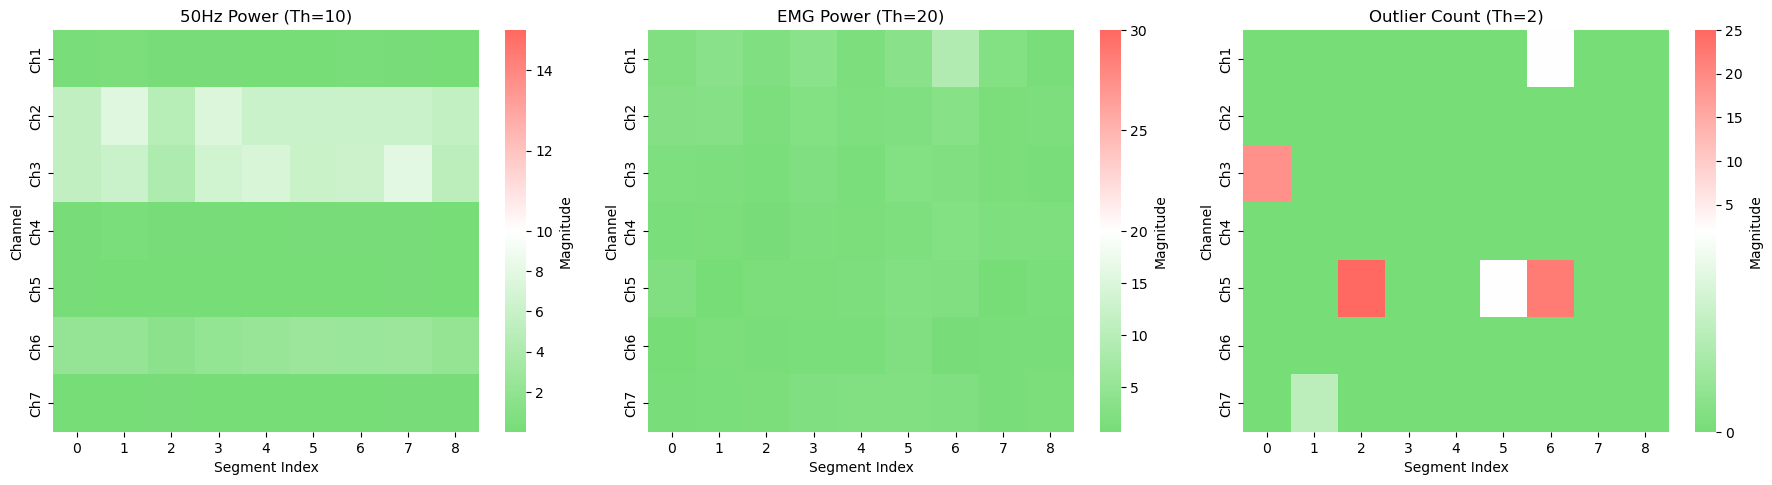


输出矩阵形状示例 (50Hz矩阵): (7, 9)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy import signal
import seaborn as sns

def eeg_quality_check(eeg_data, fs=250):
    """
    EEG信号质量检测函数
    
    参数:
    eeg_data: np.array, 形状为 (7, data_points)
    fs: int, 采样率, 默认 250
    
    返回:
    metrics_list: list, 包含4个数组 [power_50hz, power_emg, power_baseline, outlier]
                  每个数组形状为 (7, num_segments)
    """
    
        # ---------------------------------------------------------
    # 修改 1: 带通滤波 (1-100Hz)
    # ---------------------------------------------------------
    print("正在应用带通滤波 (1-100Hz)...")
    # 4阶巴特沃斯滤波器 (阶数可根据需求调整，通常EEG用2-4阶)
    nyq = 0.5 * fs
    low = 1 / nyq
    high = 100 / nyq
    b, a = signal.butter(4, [low, high], btype='band')
    
    # 使用 filtfilt 进行零相位滤波，避免波形时移
    eeg_data_filtered = signal.filtfilt(b, a, eeg_data, axis=1)
    
    # 后续计算使用滤波后的数据
    data = eeg_data_filtered

    n_channels, n_points = data.shape
    seg_len = 250  # 定义每段的数据点数 N=500
    n_segs = n_points // seg_len # 计算总段数
    print('number of segs:', n_segs)
    # 阈值设定 [50Hz, EMG,  Outlier]
    thresh = [10, 20,  2]  # this is based on NeuraDock hardware performances, you can modify based on youor application requirements
    
    # 初始化存储结果的矩阵: 形状 (7行, n_segs列)
    # 用于存储4种特征值
    res_50hz = np.zeros((n_channels, n_segs))
    res_emg = np.zeros((n_channels, n_segs))
    res_out = np.zeros((n_channels, n_segs))
    
    # 1. 计算指标
    print(f"开始处理数据: {n_channels} 通道, {n_segs} 段 (每段 {seg_len} 点)...")
    
    for ch in range(n_channels):
        for i in range(n_segs):
            # 获取当前段的数据索引
            start_idx = i * seg_len
            end_idx = start_idx + seg_len
            segment = data[ch, start_idx:end_idx]
            
            # 计算 Welch PSD (根据需求 nperseg=2048)
            # 注意: 当数据长度(500) < nperseg(2048)时，scipy会自动进行零填充(zero-padding)
            f, Pxx = signal.welch(segment, fs=fs, nperseg=2048)
            
            # 计算特征值 (根据需求逻辑)
            # 50Hz Power (49-51Hz)
            power_50hz = np.sum(Pxx[np.where((f >= 49) & (f <= 51))])
            
            # EMG Power (20-40Hz)
            power_emg = np.sum(Pxx[np.where((f >= 20) & (f <= 40))])
            
            
            # Outlier Count (<= -50 or >= 50)
            outlier = np.where((segment <= -100) | (segment >= 100))[0].shape[0]
            
            # 存入矩阵
            res_50hz[ch, i] = power_50hz
            res_emg[ch, i] = power_emg
            res_out[ch, i] = outlier

    # 2. 可视化 - 时域图 (Subplot 7,1)
    fig_time, axes = plt.subplots(7, 1, figsize=(15, 12), sharex=True)
    fig_time.suptitle('EEG Time Domain Quality Check', fontsize=16)
    
    time_axis = np.arange(n_points) / fs
    
    for ch in range(n_channels):
        ax = axes[ch]
        # 画原始波形
        ax.plot(time_axis, data[ch, :], color='black', linewidth=0.8, alpha=0.8)
        ax.set_ylabel(f'Ch {ch+1}')
        
        # 标记噪音段
        for i in range(n_segs):
            t_start = i * seg_len / fs
            t_end = (i + 1) * seg_len / fs
            
            # 获取当前段的指标
            p50 = res_50hz[ch, i]
            pemg = res_emg[ch, i]
            pout = res_out[ch, i]
            
            # 颜色标记逻辑 (优先级: 50Hz > EMG > Baseline/Outlier)
            # 使用 axvspan 绘制背景色
            if p50 > thresh[0]:
                ax.axvspan(t_start, t_end, color='red', alpha=0.3, lw=0)
            elif pemg > thresh[1]:
                ax.axvspan(t_start, t_end, color='blue', alpha=0.3, lw=0)
            elif (pout > thresh[2]):
                ax.axvspan(t_start, t_end, color='gray', alpha=0.5, lw=0)
                
    axes[-1].set_xlabel('Time (s)')
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    
    # 3. 可视化 - 热力图 (4个 Heatmaps)
    # ---------------------------------------------------------
    # 修改 2: 热力图可视化 (绿-白-红，阈值居中)
    # ---------------------------------------------------------
    fig_heat, axes_heat = plt.subplots(1, 3, figsize=(18, 5))
    
    
    metrics = [res_50hz, res_emg,  res_out]
    titles = [f'50Hz Power (Th={thresh[0]})', 
              f'EMG Power (Th={thresh[1]})', 
              f'Outlier Count (Th={thresh[2]})']
    
    # 自定义 Colormap: 绿色 -> 白色 -> 红色
    # 0.0=Green, 0.5=White, 1.0=Red
    custom_cmap = mcolors.LinearSegmentedColormap.from_list(
        "GreenWhiteRed", ["#77dd77", "#ffffff", "#ff6961"]
    )
    
    for idx, ax in enumerate(axes_heat.flat):
        current_data = metrics[idx]
        current_thresh = thresh[idx]
        
        # 为了防止 TwoSlopeNorm 报错，确保 vmin < vcenter < vmax
        # 即使数据全都大于或全都小于阈值，也能正确显示
        d_min = np.min(current_data)
        d_max = np.max(current_data)
        
        # 动态设定显示范围，确保阈值包含在范围内
        vmin = min(d_min, current_thresh * 0.5) 
        vmax = max(d_max, current_thresh * 1.5)
        
        if vmin == vmax: # 极端情况防止报错
            vmin -= 0.1
            vmax += 0.1
            
        # 关键: TwoSlopeNorm 将 vcenter 映射到 colormap 的中间颜色 (白色)
        norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=current_thresh, vmax=vmax)
        
        sns.heatmap(current_data, ax=ax, 
                    cmap=custom_cmap, 
                    norm=norm,  # 应用归一化
                    cbar=True,
                    cbar_kws={'label': 'Magnitude'},
                    yticklabels=[f'Ch{i+1}' for i in range(n_channels)])
        
        ax.set_title(titles[idx])
        ax.set_xlabel('Segment Index')
        ax.set_ylabel('Channel')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    
    plt.show()

    
    return [res_50hz, res_emg,  res_out],eeg_data_filtered

# ==========================================
# 测试代码 (生成假数据进行演示)
# ==========================================
if __name__ == "__main__":
    
    # 运行检测函数
    result_arrays ,eeg_data_filtered= eeg_quality_check(eeg_data, 250)
    
    print("\n输出矩阵形状示例 (50Hz矩阵):", result_arrays[0].shape)


检测结果:
  - 坏通道索引 (噪音占比 > 40.0%): []
  - 好通道索引: [0 1 2 3 4 5 6]
数据清洗完成: 原始长度 2325 -> 清洗后 1575
信息保留率: 67.74%


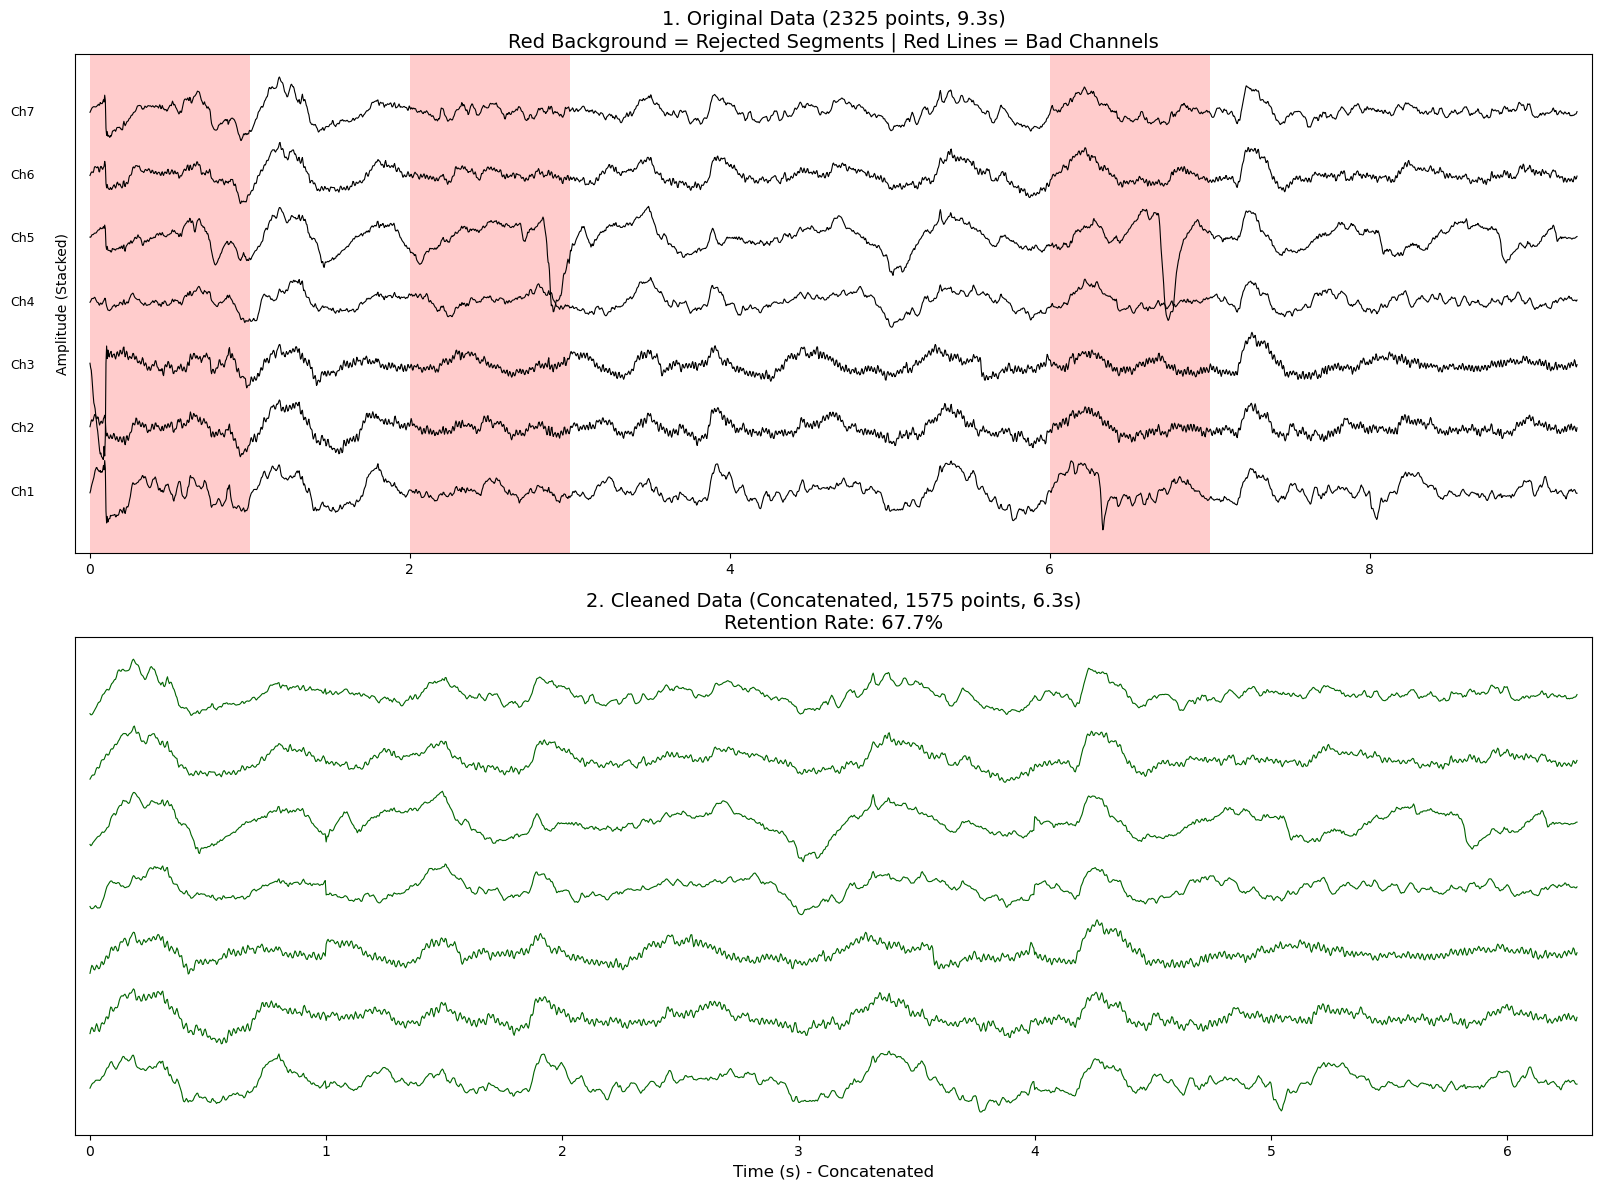

In [17]:
def clean_eeg_data(eeg_data, metrics, thresh, seg_len=250, bad_ch_ratio=0.4):
    """
    基于质量检测结果清洗EEG数据 (最大化信息保留策略)
    
    参数:
    eeg_data: 原始数据 (7, points)
    metrics: eeg_quality_check 返回的列表 [res_50hz, res_emg, res_out]
    thresh: 阈值列表 [10, 20, 2]
    seg_len: 分段长度 (500)
    bad_ch_ratio: 判定坏通道的比例阈值 (默认0.4，即超过40%的时间是坏的，则认为通道坏了)
    
    返回:
    clean_data: 清洗后拼接的数据 (可能变短)
    keep_mask: 保留的数据点掩码
    info: 包含坏通道索引和保留比例的字典
    """
    
    n_channels, n_points = eeg_data.shape
    n_segs = metrics[0].shape[1]
    
    # 1. 生成综合噪音掩码 (Binary Mask)
    # 形状 (7, n_segs), True表示该段该通道是坏的
    # 只要满足任意一个噪音条件，就标记为 True
    mask_50hz = metrics[0] > thresh[0]
    mask_emg  = metrics[1] > thresh[1]
    mask_out  = metrics[2] > thresh[2]
    
    total_noise_mask = mask_50hz | mask_emg | mask_out
    
    # -----------------------------------------------------------
    # 策略第一步: 识别并隔离 "坏通道" (Bad Channels)
    # -----------------------------------------------------------
    # 计算每个通道的坏段比例
    bad_seg_counts = np.sum(total_noise_mask, axis=1) # 每个通道有多少个坏段
    bad_ratios = bad_seg_counts / n_segs
    
    # 如果坏段比例 > 40%，标记为坏通道
    bad_channel_indices = np.where(bad_ratios > bad_ch_ratio)[0]
    good_channel_indices = np.where(bad_ratios <= bad_ch_ratio)[0]
    
    print(f"检测结果:")
    print(f"  - 坏通道索引 (噪音占比 > {bad_ch_ratio*100}%): {bad_channel_indices}")
    print(f"  - 好通道索引: {good_channel_indices}")
    
    # -----------------------------------------------------------
    # 策略第二步: 基于 "好通道" 决定要删除哪些时间段
    # -----------------------------------------------------------
    # 我们只看好通道的噪音情况。如果好通道里也有噪音，说明是病人动了或者有大干扰
    if len(good_channel_indices) > 0:
        # 只提取好通道的mask
        good_ch_mask = total_noise_mask[good_channel_indices, :]
        #在该段中，如果任意一个好通道坏了，我们就认为这一段数据不能用
        # (axis=0 求 '或'，即列方向只要有一个True，该段就是True)
        segments_to_reject = np.any(good_ch_mask, axis=0)
    else:
        # 极端情况：所有通道都坏了，保留所有段或者全部删除
        # 这里选择保留所有段，但在坏通道列表中体现
        print("警告: 所有通道均被判定为坏通道！")
        segments_to_reject = np.zeros(n_segs, dtype=bool)

    # -----------------------------------------------------------
    # 3. 物理删除/拼接数据
    # -----------------------------------------------------------
    # 将段掩码 (n_segs,) 扩展回点掩码 (n_points,)
    # np.repeat: [0, 1] -> [0,0,0... , 1,1,1...]
    points_to_reject = np.repeat(segments_to_reject, seg_len)
    
    # 处理数据长度可能不能整除seg_len的情况 (补齐)
    if len(points_to_reject) < n_points:
        padding = np.zeros(n_points - len(points_to_reject), dtype=bool)
        points_to_reject = np.concatenate([points_to_reject, padding])
    elif len(points_to_reject) > n_points:
        points_to_reject = points_to_reject[:n_points]
        
    points_to_keep = ~points_to_reject
    
    # 执行删除 (只保留 mask 为 True 的列)
    clean_data = eeg_data[:, points_to_keep]
    
    # -----------------------------------------------------------
    # 4. (可选) 简单的坏通道修复：用0填充坏通道
    # -----------------------------------------------------------
    # 注意：更高级的方法是用球面样条插值(Spherical Spline Interpolation)，
    # 但那需要电极坐标位置。这里为了保持数据形状，如果不删除通道，通常置零或保留原样。
    # 这里我们选择保留原样，但在返回信息中告知用户。
    
    retention_rate = clean_data.shape[1] / n_points
    print(f"数据清洗完成: 原始长度 {n_points} -> 清洗后 {clean_data.shape[1]}")
    print(f"信息保留率: {retention_rate:.2%}")
    
    info = {
        'bad_channels': bad_channel_indices,
        'retention_rate': retention_rate,
        'rejected_segments_count': np.sum(segments_to_reject)
    }
    
    return clean_data, points_to_keep, info
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# =========================================================
# 辅助函数: 寻找连续的False区域 (用于画红色背景)
# =========================================================
def find_rejected_intervals(mask):
    """
    输入: bool mask (True=Keep, False=Reject)
    输出: list of tuples [(start_idx, end_idx), ...]
    """
    # 补充边界以处理开头或结尾就被拒绝的情况
    padded_mask = np.concatenate(([True], mask, [True]))
    # 寻找状态变化点 (True -> False 或 False -> True)
    diff = np.diff(padded_mask.astype(int))
    
    # -1 表示从 True 变 False (拒绝开始)
    #  1 表示从 False 变 True (拒绝结束)
    starts = np.where(diff == -1)[0]
    ends = np.where(diff == 1)[0]
    
    return list(zip(starts, ends))

# =========================================================
# 核心可视化函数
# =========================================================
def visualize_cleaning_comparison(raw_data, clean_data, keep_mask, info, fs=250):
    """
    画出专业的对比图: 原始数据 vs 清洗后数据
    使用堆叠(Waterfall)方式绘制，避免重叠。
    """
    n_channels = raw_data.shape[0]
    bad_channels = info['bad_channels']
    
    # 计算Y轴偏移量 (Offset)，防止通道重叠
    # 取数据标准差的5倍作为通道间距
    std_val = np.std(raw_data)
    offset_step = std_val * 6 
    
    # 创建时间轴
    t_raw = np.arange(raw_data.shape[1]) / fs
    t_clean = np.arange(clean_data.shape[1]) / fs
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), sharex=False)
    
    # -----------------------------------------------------
    # 子图 1: 原始数据 (标记删除区域和坏通道)
    # -----------------------------------------------------
    ax1.set_title(f"1. Original Data ({raw_data.shape[1]} points, {raw_data.shape[1]/fs:.1f}s)\n"
                  f"Red Background = Rejected Segments | Red Lines = Bad Channels", fontsize=14)
    
    # 1.1 绘制红色背景 (被剔除的时间段)
    intervals = find_rejected_intervals(keep_mask)
    for start, end in intervals:
        ax1.axvspan(start/fs, end/fs, color='red', alpha=0.2, lw=0)
    
    # 1.2 绘制每个通道的波形
    for ch in range(n_channels):
        # 计算当前通道的Y轴位置
        y_offset = ch * offset_step
        trace = raw_data[ch, :] + y_offset
        
        # 判断是否是坏通道
        if ch in bad_channels:
            # 坏通道用红色虚线，且稍微淡一点
            ax1.plot(t_raw, trace, color='red', linewidth=1, linestyle='--', alpha=0.6)
            # 在左侧Y轴标记 Bad
            ax1.text(t_raw[0]-0.5, y_offset, f"BAD Ch{ch+1}", color='red', 
                     fontsize=9, verticalalignment='center', fontweight='bold')
        else:
            # 好通道用黑色实线
            ax1.plot(t_raw, trace, color='black', linewidth=0.8)
            ax1.text(t_raw[0]-0.5, y_offset, f"Ch{ch+1}", color='black', 
                     fontsize=9, verticalalignment='center')

    ax1.set_ylabel("Amplitude (Stacked)")
    ax1.set_yticks([]) # 隐藏Y轴刻度，因为已经有offset了
    ax1.margins(x=0.01)
    
    # -----------------------------------------------------
    # 子图 2: 清洗后的数据 (拼接结果)
    # -----------------------------------------------------
    ax2.set_title(f"2. Cleaned Data (Concatenated, {clean_data.shape[1]} points, {clean_data.shape[1]/fs:.1f}s)\n"
                  f"Retention Rate: {info['retention_rate']:.1%}", fontsize=14)
    
    for ch in range(n_channels):
        y_offset = ch * offset_step
        trace = clean_data[ch, :] + y_offset
        
        if ch in bad_channels:
            # 清洗后的数据里，坏通道依然存在(只是变短了)，依然用红色标出
            # 实际上在分析时应该丢弃这行数据，或者插值
            ax2.plot(t_clean, trace, color='red', linewidth=0.5, alpha=0.3)
        else:
            # 保留的好数据用深绿色，表示"Clean"
            ax2.plot(t_clean, trace, color='#006400', linewidth=0.8)

    ax2.set_xlabel("Time (s) - Concatenated", fontsize=12)
    ax2.set_yticks([])
    ax2.margins(x=0.01)

    plt.tight_layout()
    plt.show()
# =======================================================
# 使用示例 (接上一段代码)
# =======================================================
if __name__ == "__main__":
    # 假设你已经运行了 eeg_quality_check 并得到了 metrics
    # metrics = [res_50hz, res_emg, res_out]
    # raw_data 是原始数据
    
    # 定义之前的阈值
    current_thresh = [10, 20, 2] 
    
    # 运行清洗
    cleaned_data, mask, info = clean_eeg_data(eeg_data_filtered, result_arrays, current_thresh, seg_len=250)
    # 可视化对比
    visualize_cleaning_comparison(eeg_data_filtered, cleaned_data, mask, info, 250)
    
